# Elo Score Calculation

In [1]:
import re
import os
from collections import defaultdict

In [2]:
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

## Summary

- Notebook that calcuates the Elo Score of mice competing over access to a tone associated reward port
- The data is a spreadsheet of combination of subjects (as rows) against dates (as columns)

## Importing Data

- The original data has been trimmed so that only the cells with dates, winner ID's, and relevant metadata were kept

In [5]:
home_cage_observations_df = pd.read_excel("../../data/Homecage observations.xlsx", sheet_name="Master List")

In [6]:
home_cage_observations_df["date_str"] = home_cage_observations_df["Unnamed: 0"].astype(str)

In [7]:
home_cage_observations_df.head()

,Unnamed: 0,Match,Winner,date_str
0,2022-05-02,4.3 (3) v 4.4 (4),4.4 (4),2022-05-02
1,2022-05-02,4.4 (4) v 3.4 (2),4.4 (4),2022-05-02
2,2022-05-02,4.4 (4) v 3.1 (1),4.4 (4),2022-05-02
3,2022-05-02,4.4 (4) v 3.4 (2),4.4 (4),2022-05-02
4,2022-05-02,4.3 (3) v 4.4 (4),4.4 (4),2022-05-02


In [8]:
home_cage_observations_df["winner_str"] = home_cage_observations_df["Winner "].apply(lambda x: x.strip())

## Getting a list of all the animals

- Because each cell does not contain the ID of all the animals that were competing, we will make a new column with both ID's

In [9]:
def get_all_animal_ids(animal_string):
    """
    Converts a string that contains the ID of animals, and only gets the IDs. 
    This usually removes extra characters that were added. (i.e. "1.1 v 2.2" to ("1.1", "2.2"))

    Args:
        animal_string(str): This is the first param.

    Returns:
        tuple: Of IDs of animals as strings
    """
    # Splitting by space so that we have a list of just the words
    all_words = animal_string.split()
    # Removing all words that are not numbers
    all_numbers = [num for num in all_words if re.match(r'^-?\d+(?:\.\d+)$', num)]
    return tuple(all_numbers)


In [10]:
def calculate_elo_score(subject_elo_score, agent_elo_score, k_factor=20, score=1, number_of_decimals=None):
    """
    Calculates the Elo score of a given subject given it's original score, it's opponent, 
    the K-Factor, and whether or not it has won or not. 
    The calculation is based on: https://www.omnicalculator.com/sports/elo

    Args:
        subject_elo_score(float): The original Elo score for the subject
        agent_elo_score(float): The original Elo score for the agent
        k_factor(int): k-factor, or development coefficient. 
            - It usually takes values between 10 and 40, depending on player's strength 
        score(int): the actual outcome of the game. 
            - In chess, a win counts as 1 point, a draw is equal to 0.5, and a lose gives 0.
        number_of_decimals(int): Number of decimals to round to
        
    Returns:
        int: Updated Elo score of the subject
    """
    # Calculating the Elo score
    rating_difference = agent_elo_score - subject_elo_score
    expected_score = 1 / (1 + 10 ** (rating_difference / 400))
    new_elo_score = subject_elo_score + k_factor * (score - expected_score)
    # Rounding to `number_of_decimals`
    return round(new_elo_score, number_of_decimals)

# Calculate Elo score for Home Cage Observations

# Add Cage information

In [11]:
id_to_cage = {"1.1": "1",
"2.2": "1",
"2.3": "1",
"1.4": "1",

"2.1": "2",
"1.2": "2",
"1.3": "2", 
"2.4": "2",

"4.1 (1)": "3", 
"3.2 (2)": "3", 
"4.2 (3)": "3", 
"3.3 (4)": "3", 

"3.1 (1)": "4",
"3.4 (2)": "4", 
"4.3 (3)": "4",
"4.4 (4)": "4"}

In [12]:
home_cage_observations_df["cage"] = home_cage_observations_df["winner_str"].map(id_to_cage)

In [13]:
home_cage_observations_df.head()

,Unnamed: 0,Match,Winner,date_str,winner_str,cage
0,2022-05-02,4.3 (3) v 4.4 (4),4.4 (4),2022-05-02,4.4 (4),4
1,2022-05-02,4.4 (4) v 3.4 (2),4.4 (4),2022-05-02,4.4 (4),4
2,2022-05-02,4.4 (4) v 3.1 (1),4.4 (4),2022-05-02,4.4 (4),4
3,2022-05-02,4.4 (4) v 3.4 (2),4.4 (4),2022-05-02,4.4 (4),4
4,2022-05-02,4.3 (3) v 4.4 (4),4.4 (4),2022-05-02,4.4 (4),4


# Calculate Elo score for all cells

- Getting all the ID's of the animals

In [14]:
# Splitting by "v" and stripping all the spaces
home_cage_observations_df["all_animals"] = home_cage_observations_df["Match"].apply(lambda x: tuple([animal.strip() for animal in x.split("v")]))

In [15]:
home_cage_observations_df.head(n=25)

,Unnamed: 0,Match,Winner,date_str,winner_str,cage,all_animals
0,2022-05-02,4.3 (3) v 4.4 (4),4.4 (4),2022-05-02,4.4 (4),4,"(4.3 (3), 4.4 (4))"
1,2022-05-02,4.4 (4) v 3.4 (2),4.4 (4),2022-05-02,4.4 (4),4,"(4.4 (4), 3.4 (2))"
2,2022-05-02,4.4 (4) v 3.1 (1),4.4 (4),2022-05-02,4.4 (4),4,"(4.4 (4), 3.1 (1))"
3,2022-05-02,4.4 (4) v 3.4 (2),4.4 (4),2022-05-02,4.4 (4),4,"(4.4 (4), 3.4 (2))"
4,2022-05-02,4.3 (3) v 4.4 (4),4.4 (4),2022-05-02,4.4 (4),4,"(4.3 (3), 4.4 (4))"
5,2022-05-02,4.3 (3) v 4.4 (4),4.4 (4),2022-05-02,4.4 (4),4,"(4.3 (3), 4.4 (4))"
6,2022-05-02,4.4 (4) v 3.4 (2),4.4 (4),2022-05-02,4.4 (4),4,"(4.4 (4), 3.4 (2))"
7,2022-05-02,4.3 (3) v 4.4 (4),4.4 (4),2022-05-02,4.4 (4),4,"(4.3 (3), 4.4 (4))"
8,2022-05-02,4.4 (4) v 3.1 (1),4.4 (4),2022-05-02,4.4 (4),4,"(4.4 (4), 3.1 (1))"
9,2022-05-02,4.4 (4) v 3.1 (1),4.4 (4),2022-05-02,4.4 (4),4,"(4.4 (4), 3.1 (1))"


## Get the Elo score for one fight

In [16]:
# Dictionary that keeps track of the current Elo score of the subject
id_to_elo_score = defaultdict(lambda:1000)

index_to_elo_score_and_meta_data = defaultdict(dict)
# Iterating through each column which is a day
all_indexes = iter(range(0, 99999))

# Keeping track of the number of matches
id_to_match_number = defaultdict(lambda:1)
for index, row in home_cage_observations_df.iterrows():
    # Checking if there is an Nan or not
    if row["Winner "] == "nan":
        continue
    else:            
        winner_id = row["winner_str"]
    date = row["date_str"]
    # Getting the ID of the loser subject
    loser_id = list(set(row["all_animals"]) - set([winner_id]))
    loser_id = loser_id[0]
    # Getting the current Elo Score
    current_winner_rating = id_to_elo_score[winner_id] 
    current_loser_rating = id_to_elo_score[loser_id] 
    # Calculating Elo score            
    id_to_elo_score[winner_id] = calculate_elo_score(subject_elo_score=current_winner_rating, agent_elo_score=current_loser_rating, score=1, number_of_decimals=1)
    id_to_elo_score[loser_id] = calculate_elo_score(subject_elo_score=current_loser_rating, agent_elo_score=current_winner_rating, score=0, number_of_decimals=1)

    # Saving all the data for the winner
    winner_index = next(all_indexes)
    index_to_elo_score_and_meta_data[winner_index]["date"] = date
    index_to_elo_score_and_meta_data[winner_index]["match_number"] = id_to_match_number[date + winner_id]
    index_to_elo_score_and_meta_data[winner_index]["cage"] = row["cage"]
    index_to_elo_score_and_meta_data[winner_index]["subject_id"] = winner_id
    index_to_elo_score_and_meta_data[winner_index]["agent_id"] = loser_id
    index_to_elo_score_and_meta_data[winner_index]["original_elo_score"] = current_winner_rating
    index_to_elo_score_and_meta_data[winner_index]["updated_elo_score"] = id_to_elo_score[winner_id]
    index_to_elo_score_and_meta_data[winner_index]["win_draw_loss"] = 1


    # Saving all the data for the loser
    loser_index = next(all_indexes)
    index_to_elo_score_and_meta_data[loser_index]["date"] = date
    index_to_elo_score_and_meta_data[loser_index]["match_number"] = id_to_match_number[date + loser_id]
    index_to_elo_score_and_meta_data[loser_index]["cage"] = row["cage"]
    index_to_elo_score_and_meta_data[loser_index]["subject_id"] = loser_id
    index_to_elo_score_and_meta_data[loser_index]["agent_id"] = winner_id
    index_to_elo_score_and_meta_data[loser_index]["original_elo_score"] = current_loser_rating
    index_to_elo_score_and_meta_data[loser_index]["updated_elo_score"] = id_to_elo_score[loser_id]
    index_to_elo_score_and_meta_data[loser_index]["win_draw_loss"] = 0

    id_to_match_number[date + winner_id] += 1
    id_to_match_number[date + loser_id] += 1
    

In [17]:
id_to_elo_score

defaultdict(<function __main__.<lambda>()>,
            {'4.4 (4)': 1290.3,
             '4.3 (3)': 924.6,
             '3.4 (2)': 866.3,
             '3.1 (1)': 918.8,
             '4.1 (1)': 1185.0,
             '3.3 (4)': 944.7,
             '3.2 (2)': 889.6,
             '4.2 (3)': 980.7})

In [18]:
index_to_elo_score_and_meta_data[0]

{'date': '2022-05-02',
 'match_number': 1,
 'cage': '4',
 'subject_id': '4.4 (4)',
 'agent_id': '4.3 (3)',
 'original_elo_score': 1000,
 'updated_elo_score': 1010.0,
 'win_draw_loss': 1}

In [19]:
home_cage_elo_score_df = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

In [20]:
home_cage_elo_score_df

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss
0,2022-05-02,1,4,4.4 (4),4.3 (3),1000.0,1010.0,1
1,2022-05-02,1,4,4.3 (3),4.4 (4),1000.0,990.0,0
2,2022-05-02,2,4,4.4 (4),3.4 (2),1010.0,1019.7,1
3,2022-05-02,1,4,3.4 (2),4.4 (4),1000.0,990.3,0
4,2022-05-02,3,4,4.4 (4),3.1 (1),1019.7,1029.1,1
...,...,...,...,...,...,...,...,...
243,2022-05-13,4,4,3.4 (2),4.4 (4),869.6,867.9,0
244,2022-05-13,16,4,4.4 (4),4.3 (3),1286.5,1288.7,1
245,2022-05-13,4,4,4.3 (3),4.4 (4),926.8,924.6,0
246,2022-05-13,17,4,4.4 (4),3.4 (2),1288.7,1290.3,1


In [21]:
home_cage_elo_score_df[home_cage_elo_score_df["date"] == "2022-05-04"]

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss
46,2022-05-04,1,3,4.1 (1),3.3 (4),1000.0,1010.0,1
47,2022-05-04,1,3,3.3 (4),4.1 (1),1000.0,990.0,0
48,2022-05-04,2,3,4.1 (1),3.3 (4),1010.0,1019.4,1
49,2022-05-04,2,3,3.3 (4),4.1 (1),990.0,980.6,0
50,2022-05-04,3,3,4.1 (1),3.2 (2),1019.4,1028.8,1
51,2022-05-04,1,3,3.2 (2),4.1 (1),1000.0,990.6,0
52,2022-05-04,4,3,4.1 (1),3.3 (4),1028.8,1037.4,1
53,2022-05-04,3,3,3.3 (4),4.1 (1),980.6,972.0,0
54,2022-05-04,5,3,4.1 (1),3.2 (2),1037.4,1046.1,1
55,2022-05-04,2,3,3.2 (2),4.1 (1),990.6,981.9,0


In [22]:
home_cage_elo_score_df["date"]

0      2022-05-02
1      2022-05-02
2      2022-05-02
3      2022-05-02
4      2022-05-02
          ...    
243    2022-05-13
244    2022-05-13
245    2022-05-13
246    2022-05-13
247    2022-05-13
Name: date, Length: 248, dtype: object

In [23]:
home_cage_elo_score_df[home_cage_elo_score_df["date"] == "2022-05-02" ]

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss
0,2022-05-02,1,4,4.4 (4),4.3 (3),1000.0,1010.0,1
1,2022-05-02,1,4,4.3 (3),4.4 (4),1000.0,990.0,0
2,2022-05-02,2,4,4.4 (4),3.4 (2),1010.0,1019.7,1
3,2022-05-02,1,4,3.4 (2),4.4 (4),1000.0,990.3,0
4,2022-05-02,3,4,4.4 (4),3.1 (1),1019.7,1029.1,1
5,2022-05-02,1,4,3.1 (1),4.4 (4),1000.0,990.6,0
6,2022-05-02,4,4,4.4 (4),3.4 (2),1029.1,1038.0,1
7,2022-05-02,2,4,3.4 (2),4.4 (4),990.3,981.4,0
8,2022-05-02,5,4,4.4 (4),4.3 (3),1038.0,1046.6,1
9,2022-05-02,2,4,4.3 (3),4.4 (4),990.0,981.4,0


In [24]:
home_cage_elo_score_df.head(n=30)

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss
0,2022-05-02,1,4,4.4 (4),4.3 (3),1000.0,1010.0,1
1,2022-05-02,1,4,4.3 (3),4.4 (4),1000.0,990.0,0
2,2022-05-02,2,4,4.4 (4),3.4 (2),1010.0,1019.7,1
3,2022-05-02,1,4,3.4 (2),4.4 (4),1000.0,990.3,0
4,2022-05-02,3,4,4.4 (4),3.1 (1),1019.7,1029.1,1
5,2022-05-02,1,4,3.1 (1),4.4 (4),1000.0,990.6,0
6,2022-05-02,4,4,4.4 (4),3.4 (2),1029.1,1038.0,1
7,2022-05-02,2,4,3.4 (2),4.4 (4),990.3,981.4,0
8,2022-05-02,5,4,4.4 (4),4.3 (3),1038.0,1046.6,1
9,2022-05-02,2,4,4.3 (3),4.4 (4),990.0,981.4,0


In [25]:
home_cage_elo_score_df.tail()

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss
243,2022-05-13,4,4,3.4 (2),4.4 (4),869.6,867.9,0
244,2022-05-13,16,4,4.4 (4),4.3 (3),1286.5,1288.7,1
245,2022-05-13,4,4,4.3 (3),4.4 (4),926.8,924.6,0
246,2022-05-13,17,4,4.4 (4),3.4 (2),1288.7,1290.3,1
247,2022-05-13,5,4,3.4 (2),4.4 (4),867.9,866.3,0


# Plotting the Elo Score

In [26]:
# Dictionary that keeps track of the current Elo score of the subject
id_to_elo_score = defaultdict(lambda:1000)

index_to_elo_score_and_meta_data = defaultdict(dict)
# Iterating through each column which is a day
all_indexes = iter(range(0, 99999))

# Keeping track of the number of matches
cage_to_match_number = defaultdict(lambda:1)
for index, row in home_cage_observations_df.iterrows():
    # Checking if there is an Nan or not
    if row["Winner "] == "nan":
        continue
    else:            
        winner_id = row["winner_str"]
    date = row["date_str"]
    # Getting the ID of the loser subject
    loser_id = list(set(row["all_animals"]) - set([winner_id]))
    loser_id = loser_id[0]
    # Getting the current Elo Score
    current_winner_rating = id_to_elo_score[winner_id] 
    current_loser_rating = id_to_elo_score[loser_id] 
    # Calculating Elo score            
    id_to_elo_score[winner_id] = calculate_elo_score(subject_elo_score=current_winner_rating, agent_elo_score=current_loser_rating, score=1, number_of_decimals=1)
    id_to_elo_score[loser_id] = calculate_elo_score(subject_elo_score=current_loser_rating, agent_elo_score=current_winner_rating, score=0, number_of_decimals=1)

    # Saving all the data for the winner
    winner_index = next(all_indexes)
    index_to_elo_score_and_meta_data[winner_index]["date"] = date
    index_to_elo_score_and_meta_data[winner_index]["match_number"] = cage_to_match_number[date + row["cage"]]
    index_to_elo_score_and_meta_data[winner_index]["cage"] = row["cage"]
    index_to_elo_score_and_meta_data[winner_index]["subject_id"] = winner_id
    index_to_elo_score_and_meta_data[winner_index]["agent_id"] = loser_id
    index_to_elo_score_and_meta_data[winner_index]["original_elo_score"] = current_winner_rating
    index_to_elo_score_and_meta_data[winner_index]["updated_elo_score"] = id_to_elo_score[winner_id]
    index_to_elo_score_and_meta_data[winner_index]["win_draw_loss"] = 1


    # Saving all the data for the loser
    loser_index = next(all_indexes)
    index_to_elo_score_and_meta_data[loser_index]["date"] = date
    index_to_elo_score_and_meta_data[loser_index]["match_number"] = cage_to_match_number[date + row["cage"]]
    index_to_elo_score_and_meta_data[loser_index]["cage"] = row["cage"]
    index_to_elo_score_and_meta_data[loser_index]["subject_id"] = loser_id
    index_to_elo_score_and_meta_data[loser_index]["agent_id"] = winner_id
    index_to_elo_score_and_meta_data[loser_index]["original_elo_score"] = current_loser_rating
    index_to_elo_score_and_meta_data[loser_index]["updated_elo_score"] = id_to_elo_score[loser_id]
    index_to_elo_score_and_meta_data[loser_index]["win_draw_loss"] = 0

    cage_to_match_number[date + row["cage"]] += 1
    

In [27]:
home_cage_elo_score_df = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

## Turning the Dates into Numbers

In [28]:
home_cage_elo_score_df["match_hour"] = home_cage_elo_score_df["match_number"] / (home_cage_elo_score_df["match_number"].max() + 1) * 24

In [29]:
home_cage_elo_score_df["match_time"] = home_cage_elo_score_df["match_hour"].apply(lambda x: str(timedelta(hours=x)).rsplit(':', 1)[0]) 

In [30]:
home_cage_elo_score_df.head()

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,match_hour,match_time
0,2022-05-02,1,4,4.4 (4),4.3 (3),1000.0,1010.0,1,1.2,1:12
1,2022-05-02,1,4,4.3 (3),4.4 (4),1000.0,990.0,0,1.2,1:12
2,2022-05-02,2,4,4.4 (4),3.4 (2),1010.0,1019.7,1,2.4,2:24
3,2022-05-02,2,4,3.4 (2),4.4 (4),1000.0,990.3,0,2.4,2:24
4,2022-05-02,3,4,4.4 (4),3.1 (1),1019.7,1029.1,1,3.6,3:36


In [31]:
home_cage_elo_score_df["date_with_hour"] = home_cage_elo_score_df["date"].astype(str) + " " + home_cage_elo_score_df["match_time"].astype(str)

In [32]:
# Given timestamp in string
time_str = '2021-7-24 11:30'
date_format_str = '%Y-%m-%d %H:%M'
# create datetime object from timestamp string
given_time = datetime.strptime(time_str, date_format_str)

In [33]:
print(given_time)

2021-07-24 11:30:00


In [34]:
home_cage_elo_score_df["date_time"] = home_cage_elo_score_df["date_with_hour"].apply(lambda x: datetime.strptime(x, date_format_str))

In [35]:
earliest_date = home_cage_elo_score_df["date"].min()

In [36]:
latest_date = home_cage_elo_score_df["date"].max()

In [37]:
earliest_date

'2022-05-02'

In [38]:
latest_date

'2022-05-13'

In [44]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

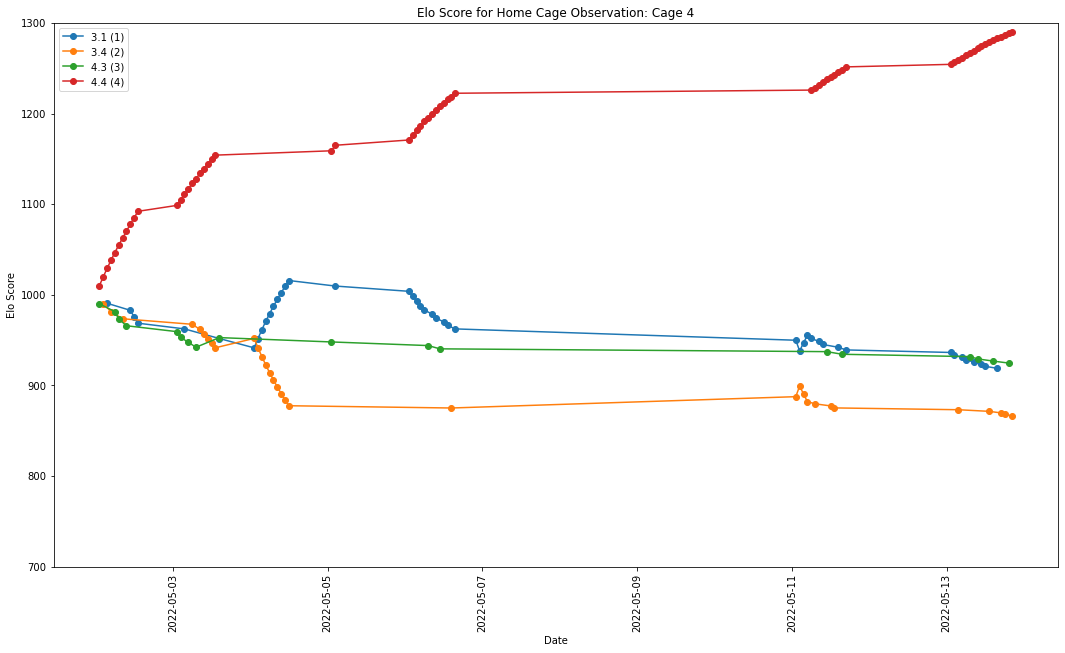

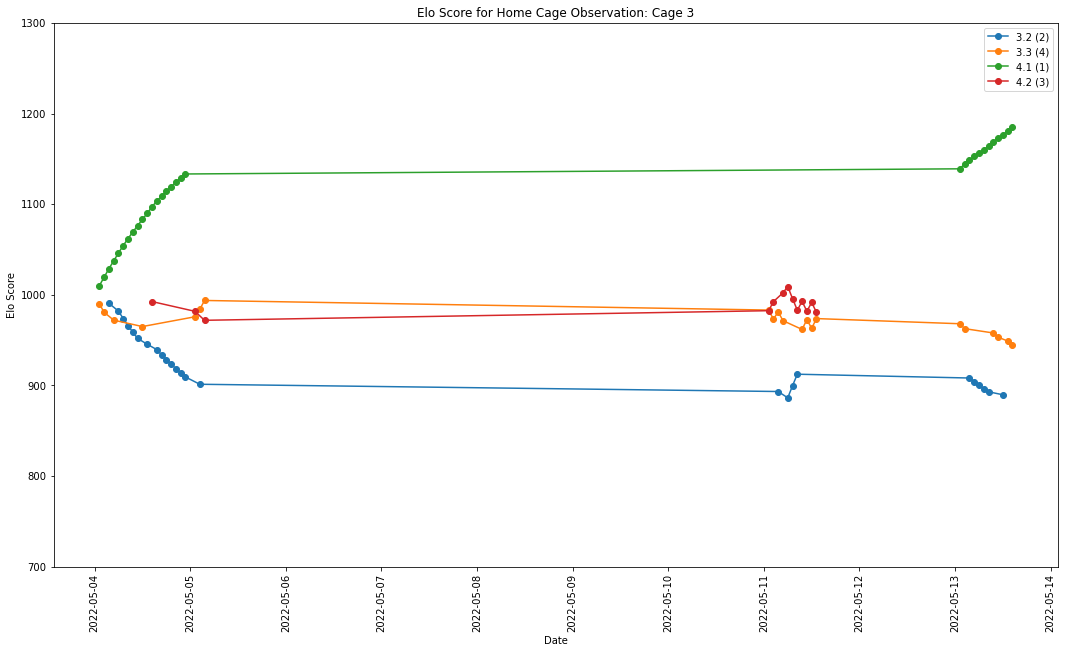

In [52]:
# Plotting for each cage
for cage in home_cage_elo_score_df["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = home_cage_elo_score_df[home_cage_elo_score_df["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in sorted(cage_df["subject_id"].unique()):
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["date_time"], subject_df["updated_elo_score"], '-o', label=subject)
    
    
    
    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
#     ax.set_ylim(0, 1)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Date")
    ax.set_ylabel("Elo Score")
    ax.set_title("Elo Score for Home Cage Observation: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    plt.xticks(rotation=90)
    plt.ylim(700, 1300) 
    file_name = "home_cage_elo_score_cage_{}_date_{}_{}.png".format(cage, earliest_date, latest_date)
    plt.savefig(os.path.join("./proc/plots/home_cage", file_name))


In [46]:
all_cages = "_".join(sorted(home_cage_elo_score_df["cage"].unique()))

In [47]:
all_cages

'3_4'

In [48]:
home_cage_elo_score_df.to_csv("./proc/home_cage_elo_score_cage_{}_date_{}_{}.csv".format(all_cages, earliest_date, latest_date))
# elo_score_df.to_excel("./proc/id_to_date_elo_score.xlsx")

# Replotting the Plots

In [53]:
# Dictionary that keeps track of the current Elo score of the subject
id_to_elo_score = defaultdict(lambda:1000)

index_to_elo_score_and_meta_data = defaultdict(dict)
# Iterating through each column which is a day
all_indexes = iter(range(0, 99999))

# Keeping track of the number of matches
cage_to_match_number = defaultdict(lambda:1)
for index, row in home_cage_observations_df.iterrows():
    # Checking if there is an Nan or not
    if row["Winner "] == "nan":
        continue
    else:            
        winner_id = row["winner_str"]
    date = row["date_str"]
    # Getting the ID of the loser subject
    loser_id = list(set(row["all_animals"]) - set([winner_id]))
    loser_id = loser_id[0]
    # Getting the current Elo Score
    current_winner_rating = id_to_elo_score[winner_id] 
    current_loser_rating = id_to_elo_score[loser_id] 
    # Calculating Elo score            
    id_to_elo_score[winner_id] = calculate_elo_score(subject_elo_score=current_winner_rating, agent_elo_score=current_loser_rating, score=1, number_of_decimals=1)
    id_to_elo_score[loser_id] = calculate_elo_score(subject_elo_score=current_loser_rating, agent_elo_score=current_winner_rating, score=0, number_of_decimals=1)

    # Saving all the data for the winner
    winner_index = next(all_indexes)
    index_to_elo_score_and_meta_data[winner_index]["date"] = date
    index_to_elo_score_and_meta_data[winner_index]["match_number"] = cage_to_match_number[row["cage"]]
    index_to_elo_score_and_meta_data[winner_index]["cage"] = row["cage"]
    index_to_elo_score_and_meta_data[winner_index]["subject_id"] = winner_id
    index_to_elo_score_and_meta_data[winner_index]["agent_id"] = loser_id
    index_to_elo_score_and_meta_data[winner_index]["original_elo_score"] = current_winner_rating
    index_to_elo_score_and_meta_data[winner_index]["updated_elo_score"] = id_to_elo_score[winner_id]
    index_to_elo_score_and_meta_data[winner_index]["win_draw_loss"] = 1


    # Saving all the data for the loser
    loser_index = next(all_indexes)
    index_to_elo_score_and_meta_data[loser_index]["date"] = date
    index_to_elo_score_and_meta_data[loser_index]["match_number"] = cage_to_match_number[row["cage"]]
    index_to_elo_score_and_meta_data[loser_index]["cage"] = row["cage"]
    index_to_elo_score_and_meta_data[loser_index]["subject_id"] = loser_id
    index_to_elo_score_and_meta_data[loser_index]["agent_id"] = winner_id
    index_to_elo_score_and_meta_data[loser_index]["original_elo_score"] = current_loser_rating
    index_to_elo_score_and_meta_data[loser_index]["updated_elo_score"] = id_to_elo_score[loser_id]
    index_to_elo_score_and_meta_data[loser_index]["win_draw_loss"] = 0

    cage_to_match_number[row["cage"]] += 1
    

In [54]:
id_to_elo_score

defaultdict(<function __main__.<lambda>()>,
            {'4.4 (4)': 1290.3,
             '4.3 (3)': 924.6,
             '3.4 (2)': 866.3,
             '3.1 (1)': 918.8,
             '4.1 (1)': 1185.0,
             '3.3 (4)': 944.7,
             '3.2 (2)': 889.6,
             '4.2 (3)': 980.7})

In [55]:
index_to_elo_score_and_meta_data[0]

{'date': '2022-05-02',
 'match_number': 1,
 'cage': '4',
 'subject_id': '4.4 (4)',
 'agent_id': '4.3 (3)',
 'original_elo_score': 1000,
 'updated_elo_score': 1010.0,
 'win_draw_loss': 1}

In [56]:
home_cage_elo_score_df = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

In [57]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

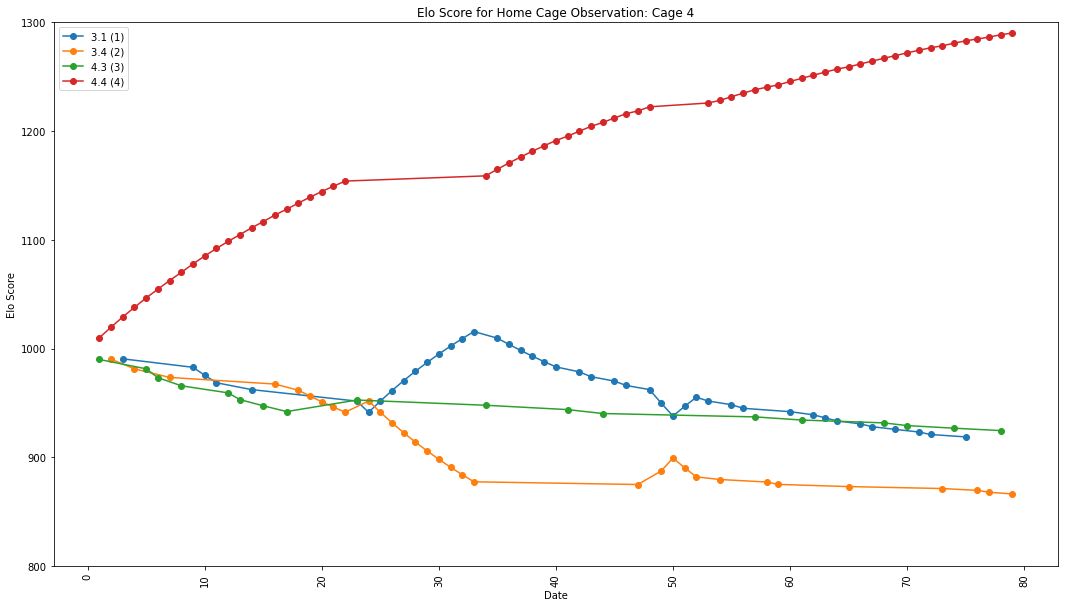

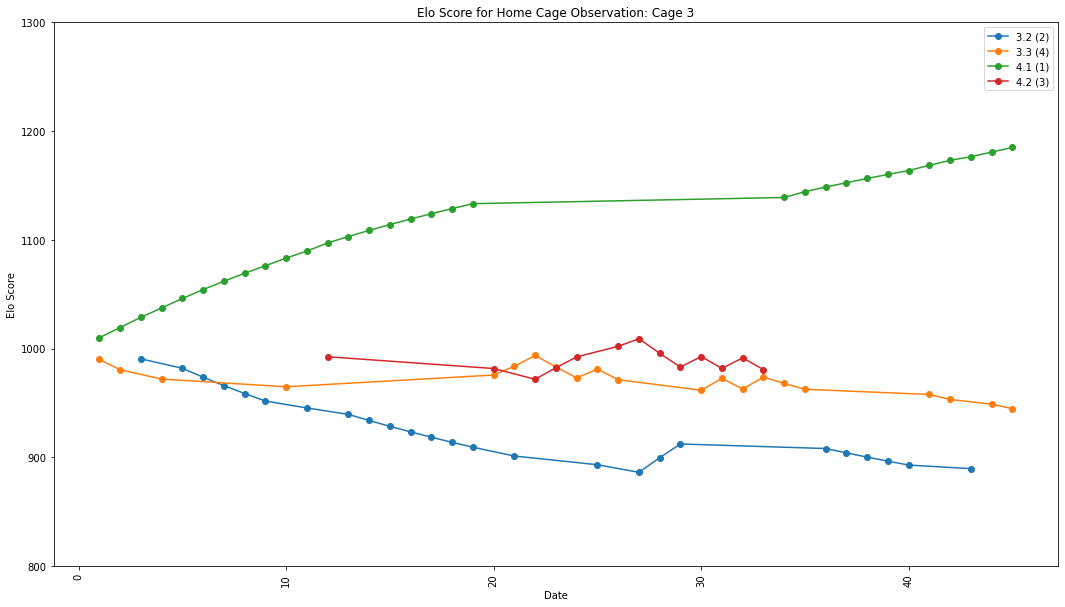

In [60]:
# Plotting for each cage
for cage in home_cage_elo_score_df["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = home_cage_elo_score_df[home_cage_elo_score_df["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in sorted(cage_df["subject_id"].unique()):
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["match_number"], subject_df["updated_elo_score"], '-o', label=subject)
    
    
    
    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
#     ax.set_ylim(0, 1)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Date")
    ax.set_ylabel("Elo Score")
    ax.set_title("Elo Score for Home Cage Observation: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    plt.xticks(rotation=90)
    plt.ylim(800, 1300) 
    file_name = "home_cage_elo_score_cage_{}_date_{}_{}.png".format(cage, earliest_date, latest_date)
    plt.savefig(os.path.join("./proc/plots/home_cage", file_name))
